In [7]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline


try:
    conn = sqlite3.connect("training_V2.db")
except Error as e:
    print(e)

#reading the data from the table that contains the labels	
df = pd.read_sql_query('SELECT * FROM filtered', conn)
df.drop(['id'], 1, inplace=True)
df.head()

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,class
0,MAHOUT-1045: committing patch with changes to ...,5
1,Add notes for coptic bug fix and scalar perfor...,5
2,cloudStack 3.0 new UI - NaaS - fix a bug that ...,1
3,"add logic to handle all 2xx response code, bug...",1
4,Fixed adding route for additional public nic o...,1


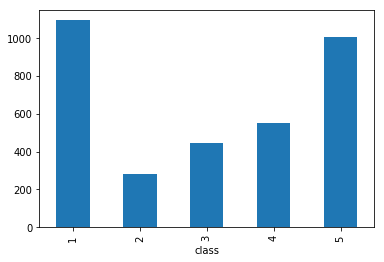

In [8]:
df.groupby('class').text.count().plot.bar(ylim=0)
plt.show()

In [9]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
df['cleaned'] = df['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df.head()

,text,class,cleaned
0,MAHOUT-1045: committing patch with changes to ...,5,mahout commit patch chang unit test cdbw numbe...
1,Add notes for coptic bug fix and scalar perfor...,5,add note coptic bug fix scalar perform improv
2,cloudStack 3.0 new UI - NaaS - fix a bug that ...,1,cloudstack new ui naa fix bug dedic paramet di...
3,"add logic to handle all 2xx response code, bug...",1,add logic handl xx respons code bug fix string...
4,Fixed adding route for additional public nic o...,1,fix ad rout addit public nic fail


In [11]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

(3377, 2389)

In [12]:
# this block is to split the dataset into training and testing set 
X = df['cleaned']
Y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# instead of doing these steps one at a time, we can use a pipeline to complete then all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       298
           2       0.95      0.93      0.94        67
           3       0.99      0.99      0.99       104
           4       0.99      0.98      0.99       131
           5       0.99      1.00      0.99       245

   micro avg       0.99      0.99      0.99       845
   macro avg       0.98      0.98      0.98       845
weighted avg       0.99      0.99      0.99       845

[[295   1   0   1   1]
 [  5  62   0   0   0]
 [  0   0 103   0   1]
 [  0   2   0 129   0]
 [  0   0   1   0 244]]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
